4 dataset: NASDAQ, Microsoft, Nvidia, Steam

NASDAQ: de beurs van NASDAQ
Microsoft: de beurs van Microsoft
Nvidia: de beurs van Nvidia
Steam: all spelen op de steam store

datums van de data gaan van 2007-01-01 tot 2023-01-01 want dit is de overlap van alle datasets
deze zijn handmatig gevonden.



problemen:  
veel moeite om de count en count cumtulatief te berekenen bij steam
.take geeft soms een error als het opnieuw wordt uitgevoerd

besluit: de beuren zijn aan elkaar gelinkt, maar de Steam dataset heeft geen correlatie behalve 

In [31]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]") \
                    .getOrCreate()

In [99]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pyspark.sql.functions import to_date, date_format, avg, sum
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# start_date = '2017-06-12'

# end_date='2021-03-31'




### de parameters:


In [ ]:
start_date = '2007-01-01'

end_date='2023-01-01'

days=30

### model werking

In [100]:

df = spark.read.option("delimiter", ",").option('header', 'true').csv("Data/merged_data.csv")
df = df.withColumn('Release Date', to_date(df['Release Date'], 'd MMM, yyyy'))
df = df.withColumn('Release Date', date_format(df['Release Date'], 'yyyy-MM-dd'))

df = df.filter(df['Release Date'].isNotNull())

# df.show()

# df_Steam = df.rdd
# df_Steam_loc = df_Steam.map(lambda r: (r['Release Date'],float(r['Release Date'].collect()))) #float(r['Open']),float(r['High']),float(r['Low']),float(r['Close']),int(r['Volume'])
# df_Steam_loc = df_Steam_loc.filter(lambda t:start_date<= t[0] <= end_date)
df_count = df.groupBy('Release Date').count()


# Count the number of games released each day
df = df.groupBy('Release Date').count()

# Calculate the cumulative count
df = df.withColumn('count_cumulative', F.sum('count').over(Window.orderBy('Release Date')))

window = Window.orderBy('Release Date').rowsBetween(-1*days, 0)  # Change the range according to your needs

df = df.withColumn('moving_average', avg(df['count']).over(window))


df_steam= df.rdd

df_steam_loc = df_steam.map(lambda r: (r['Release Date'],float(r['count']),float(r['count_cumulative']),float(r['moving_average']))) #float(r['Open']),float(r['High']),float(r['Low']),float(r['Close']),int(r['Volume'])
df_steam_loc = df_steam_loc.filter(lambda t:start_date<= t[0] <= end_date)

df_steam_loc.take(10)


[('2007-01-12', 1.0, 52.0, 1.8571428571428572),
 ('2007-01-24', 1.0, 53.0, 1.8275862068965518),
 ('2007-02-14', 1.0, 54.0, 1.8),
 ('2007-02-27', 1.0, 55.0, 1.7741935483870968),
 ('2007-03-06', 1.0, 56.0, 1.7741935483870968),
 ('2007-03-13', 1.0, 57.0, 1.7741935483870968),
 ('2007-03-15', 5.0, 62.0, 1.903225806451613),
 ('2007-03-20', 2.0, 64.0, 1.935483870967742),
 ('2007-03-22', 1.0, 65.0, 1.935483870967742),
 ('2007-03-27', 1.0, 66.0, 1.935483870967742)]

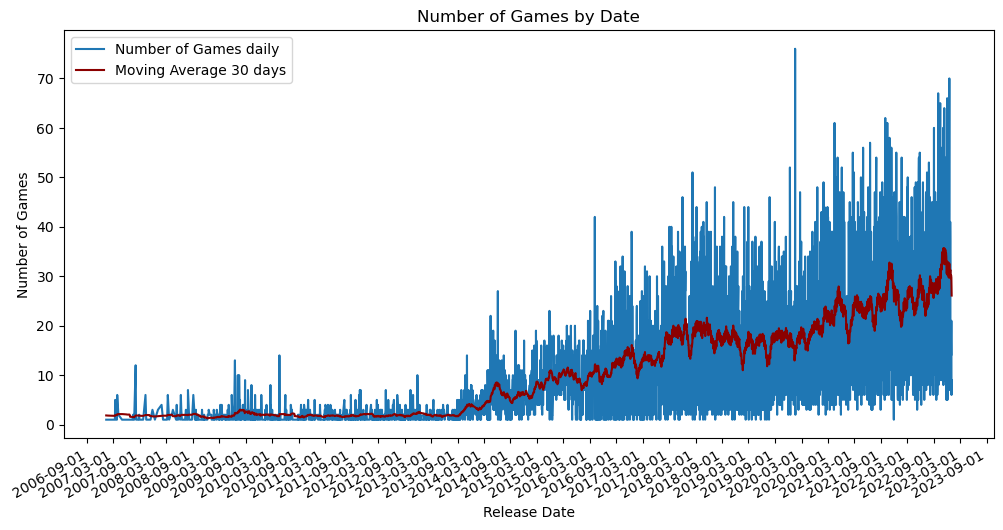

In [107]:
x=df_steam_loc.map(lambda t: t[0]).collect()
y=df_steam_loc.map(lambda t: t[1]).collect()
y1=df_steam_loc.map(lambda t: t[3]).collect()

x = [mdates.datestr2num(i) for i in x]
# Plot
plt.figure(figsize=(12,6))
plt.plot(x, y, label='Number of Games daily')
plt.plot(x, y1, color='darkred', label=f'Moving Average {days} days')
plt.xlabel('Release Date')
plt.ylabel('Number of Games')
plt.title('Number of Games by Date')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6)) 
plt.gcf().autofmt_xdate()  

plt.show()


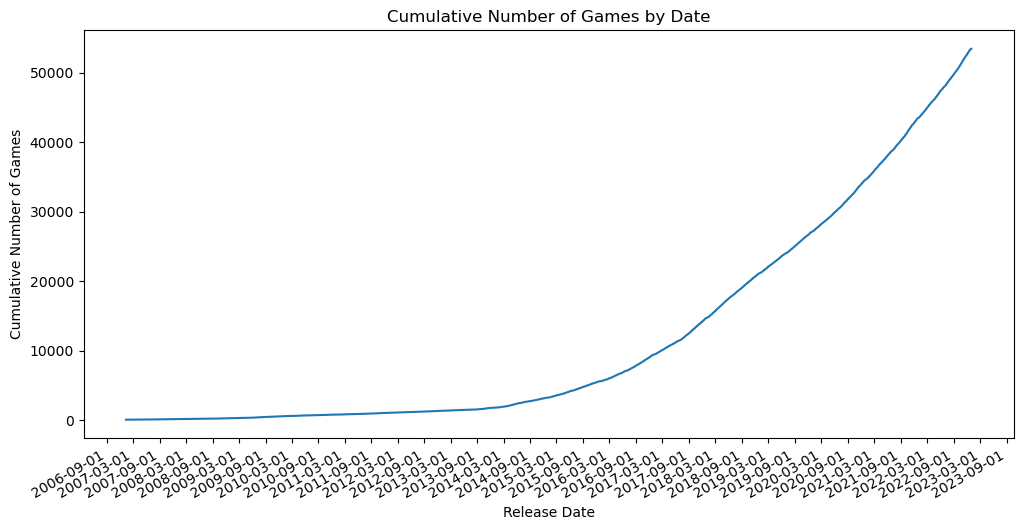

In [102]:
x=df_steam_loc.map(lambda t: t[0]).collect()
y=df_steam_loc.map(lambda t: t[2]).collect()

x = [mdates.datestr2num(i) for i in x]

# Plot
plt.figure(figsize=(12,6))
plt.plot(x, y)
plt.xlabel('Release Date')
plt.ylabel('Cumulative Number of Games')
plt.title('Cumulative Number of Games by Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6)) 
plt.gcf().autofmt_xdate()

plt.show()

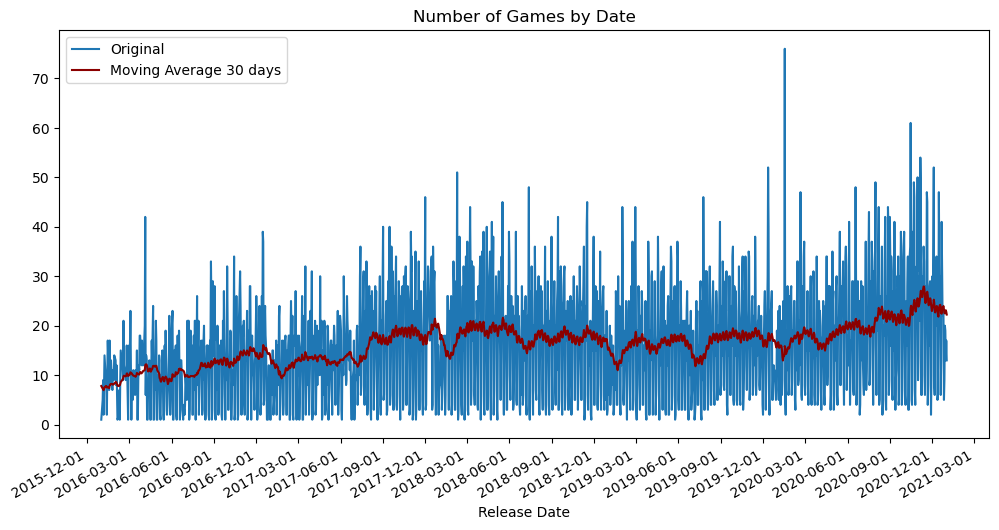

In [106]:
df_steam_loc_special = df_steam_loc.filter(lambda t:"2016-01-01"<= t[0] <= "2021-01-01")

x=df_steam_loc_special.map(lambda t: t[0]).collect()
y=df_steam_loc_special.map(lambda t: t[1]).collect()
y1=df_steam_loc_special.map(lambda t: t[3]).collect()

x = [mdates.datestr2num(i) for i in x]

plt.figure(figsize=(12,6))
plt.plot(x, y, label='Original')
plt.plot(x, y1, color='darkred', label=f'Moving Average {days} days')
plt.xlabel('Release Date')
plt.title('Number of Games by Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
plt.gcf().autofmt_xdate()  
plt.legend()

plt.show()


In [61]:
df = spark.read.option("delimiter", ",").option('header', 'true').csv("Data/NASDAQDay.csv")
print(df.describe())
df_NAS = df.rdd

df_NAS.take(10)


DataFrame[summary: string, Date: string, Open: string, High: string, Low: string, Close: string, Adj Close: string, Volume: string]


[Row(Date='1971-02-05', Open='100.000000', High='100.000000', Low='100.000000', Close='100.000000', Adj Close='100.000000', Volume='0'),
 Row(Date='1971-02-08', Open='100.839996', High='100.839996', Low='100.839996', Close='100.839996', Adj Close='100.839996', Volume='0'),
 Row(Date='1971-02-09', Open='100.760002', High='100.760002', Low='100.760002', Close='100.760002', Adj Close='100.760002', Volume='0'),
 Row(Date='1971-02-10', Open='100.690002', High='100.690002', Low='100.690002', Close='100.690002', Adj Close='100.690002', Volume='0'),
 Row(Date='1971-02-11', Open='101.449997', High='101.449997', Low='101.449997', Close='101.449997', Adj Close='101.449997', Volume='0'),
 Row(Date='1971-02-12', Open='102.050003', High='102.050003', Low='102.050003', Close='102.050003', Adj Close='102.050003', Volume='0'),
 Row(Date='1971-02-16', Open='102.190002', High='102.190002', Low='102.190002', Close='102.190002', Adj Close='102.190002', Volume='0'),
 Row(Date='1971-02-17', Open='101.739998'

In [62]:
scale=50
df_NAS_loc = df_NAS.map(lambda r: (r['Date'],float(r['High'])/scale,float(r['Low'])/scale)) #float(r['Open']),float(r['High']),float(r['Low']),float(r['Close']),int(r['Volume'])
df_NAS_loc = df_NAS_loc.filter(lambda t:start_date<= t[0] <= end_date)

df_NAS_loc.take(10)

[('2007-01-03', 49.09240234, 47.893198240000004),
 ('2007-01-04', 49.2102002, 48.275),
 ('2007-01-05', 48.90140136, 48.411801759999996),
 ('2007-01-08', 48.91259766, 48.42259766),
 ('2007-01-09', 48.99740234, 48.47120118),
 ('2007-01-10', 49.22680176, 48.55799804),
 ('2007-01-11', 49.78919922, 49.26779786),
 ('2007-01-12', 50.05640136, 49.63080078),
 ('2007-01-16', 50.17859864, 49.87839844),
 ('2007-01-17', 49.93859864, 49.51660156)]

C:\Users\joshu\AppData\Local\Temp\ipykernel_27176\4014161092.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(x, y1, linestyle='solid', marker='None', label='High')
C:\Users\joshu\AppData\Local\Temp\ipykernel_27176\4014161092.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(x, y2, linestyle='solid', marker='None', label='Low')


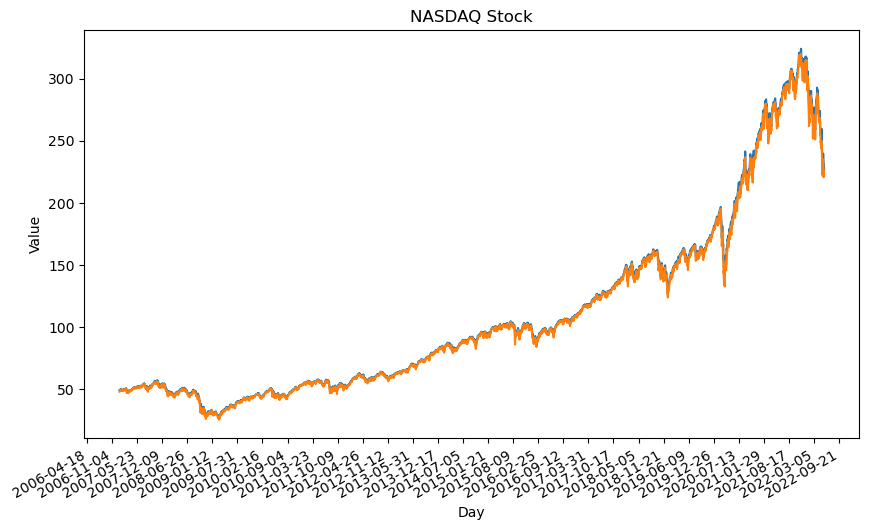

In [63]:
x=df_NAS_loc.map(lambda t: t[0]).collect()
y1=df_NAS_loc.map(lambda t: t[1]).collect()
y2=df_NAS_loc.map(lambda t: t[2]).collect()



x = [mdates.datestr2num(i) for i in x]

plt.figure(figsize=(10, 6))
# Plot y1 (high)
plt.plot_date(x, y1, linestyle='solid', marker='None', label='High')

# Plot y2 (low)
plt.plot_date(x, y2, linestyle='solid', marker='None', label='Low')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('NASDAQ Stock')

# Format the x-axis to display dates in a more readable format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200))  
plt.gcf().autofmt_xdate() 

plt.show()


In [64]:

df = spark.read.option("delimiter", ",").option('header', 'true').csv("Data/Microsoft_Stock.csv")
print(df.describe())
df_MS = df.rdd


df_MS.take(10)


DataFrame[summary: string, Date: string, Open: string, High: string, Low: string, Close: string, Volume: string]


[Row(Date='4/1/2015 16:00:00', Open='40.6', High='40.76', Low='40.31', Close='40.72', Volume='36865322'),
 Row(Date='4/2/2015 16:00:00', Open='40.66', High='40.74', Low='40.12', Close='40.29', Volume='37487476'),
 Row(Date='4/6/2015 16:00:00', Open='40.34', High='41.78', Low='40.18', Close='41.55', Volume='39223692'),
 Row(Date='4/7/2015 16:00:00', Open='41.61', High='41.91', Low='41.31', Close='41.53', Volume='28809375'),
 Row(Date='4/8/2015 16:00:00', Open='41.48', High='41.69', Low='41.04', Close='41.42', Volume='24753438'),
 Row(Date='4/9/2015 16:00:00', Open='41.25', High='41.62', Low='41.25', Close='41.48', Volume='25723861'),
 Row(Date='4/10/2015 16:00:00', Open='41.63', High='41.95', Low='41.41', Close='41.72', Volume='28022002'),
 Row(Date='4/13/2015 16:00:00', Open='41.4', High='42.06', Low='41.39', Close='41.76', Volume='30276692'),
 Row(Date='4/14/2015 16:00:00', Open='41.8', High='42.03', Low='41.39', Close='41.65', Volume='24244382'),
 Row(Date='4/15/2015 16:00:00', Open=

In [65]:

df_MS_loc = df_MS.map(lambda r: (r['Date'],float(r['High']),float(r['Low']))) #float(r['Open']),float(r['High']),float(r['Low']),float(r['Close']),int(r['Volume'])
df_MS_loc = df_MS_loc.map(lambda r: (r[0].split(' ')[0].split('/')[2] + '-' + r[0].split(' ')[0].split('/')[0].zfill(2) + '-' + r[0].split(' ')[0].split('/')[1].zfill(2), r[1], r[2]))
df_MS_loc = df_MS_loc.filter(lambda t:start_date<= t[0] <= end_date)

df_MS_loc.take(10)

[('2015-04-01', 40.76, 40.31),
 ('2015-04-02', 40.74, 40.12),
 ('2015-04-06', 41.78, 40.18),
 ('2015-04-07', 41.91, 41.31),
 ('2015-04-08', 41.69, 41.04),
 ('2015-04-09', 41.62, 41.25),
 ('2015-04-10', 41.95, 41.41),
 ('2015-04-13', 42.06, 41.39),
 ('2015-04-14', 42.03, 41.39),
 ('2015-04-15', 42.46, 41.68)]

C:\Users\joshu\AppData\Local\Temp\ipykernel_27176\3839316999.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(x, y1, linestyle='solid', marker='None', label='High')
C:\Users\joshu\AppData\Local\Temp\ipykernel_27176\3839316999.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(x, y2, linestyle='solid', marker='None', label='Low')


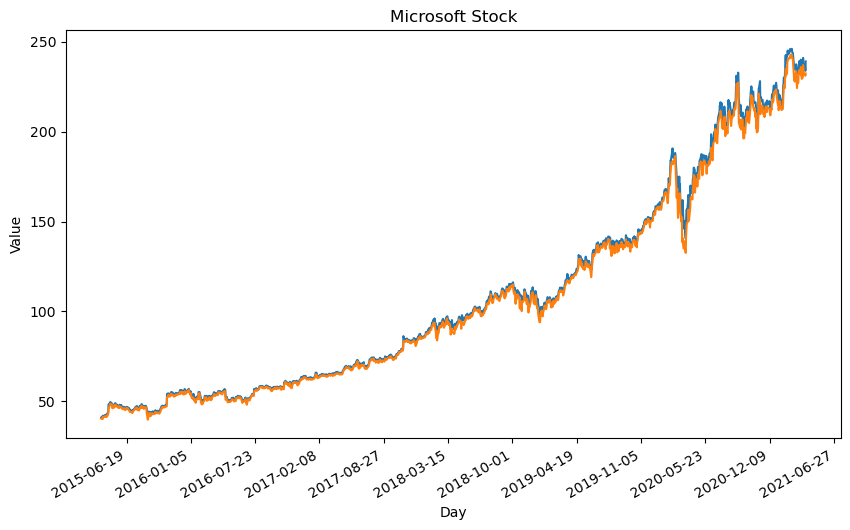

In [66]:
x=df_MS_loc.map(lambda t: t[0]).collect()
y1=df_MS_loc.map(lambda t: t[1]).collect()
y2=df_MS_loc.map(lambda t: t[2]).collect()



# Convert 'x' to datetime format
x = [mdates.datestr2num(i) for i in x]

plt.figure(figsize=(10, 6))
# Plot y1 (high)
plt.plot_date(x, y1, linestyle='solid', marker='None', label='High')

# Plot y2 (low)
plt.plot_date(x, y2, linestyle='solid', marker='None', label='Low')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Microsoft Stock')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200))  
plt.gcf().autofmt_xdate() 

plt.show()


In [67]:
df = spark.read.option("delimiter", ",").option('header', 'true').csv("Data/NVDA.csv")
print(df.describe())
df_NVDA = df.rdd

df_NVDA.take(10)


DataFrame[summary: string, Date: string, Open: string, High: string, Low: string, Close: string, Adj Close: string, Volume: string]


[Row(Date='2017-06-12', Open='36.470001', High='37.924999', Low='35.527500', Close='37.492500', Adj Close='37.076328', Volume='169753200'),
 Row(Date='2017-06-13', Open='38.599998', High='38.692501', Low='36.412498', Close='37.849998', Adj Close='37.429855', Volume='167250400'),
 Row(Date='2017-06-14', Open='37.880001', High='38.514999', Low='37.125000', Close='37.930000', Adj Close='37.508972', Volume='118464000'),
 Row(Date='2017-06-15', Open='36.740002', High='38.400002', Low='36.625000', Close='38.092499', Adj Close='37.669662', Volume='96382400'),
 Row(Date='2017-06-16', Open='38.189999', High='38.674999', Low='37.560001', Close='37.904999', Adj Close='37.484249', Volume='92496000'),
 Row(Date='2017-06-19', Open='38.352501', High='39.382500', Low='38.314999', Close='39.330002', Adj Close='38.893440', Volume='77817600'),
 Row(Date='2017-06-20', Open='39.757500', High='40.435001', Low='39.230000', Close='39.272499', Adj Close='38.836567', Volume='109544400'),
 Row(Date='2017-06-21',

In [68]:
df_NVDA_loc= df_NVDA.map(lambda r: (r['Date'],float(r['High']),float(r['Low']))) #float(r['Open']),float(r['High']),float(r['Low']),float(r['Close']),int(r['Volume'])

df_NVDA_loc = df_NVDA_loc.filter(lambda t:start_date<= t[0] <= end_date)


df_NVDA_loc.take(10)


[('2017-06-12', 37.924999, 35.5275),
 ('2017-06-13', 38.692501, 36.412498),
 ('2017-06-14', 38.514999, 37.125),
 ('2017-06-15', 38.400002, 36.625),
 ('2017-06-16', 38.674999, 37.560001),
 ('2017-06-19', 39.3825, 38.314999),
 ('2017-06-20', 40.435001, 39.23),
 ('2017-06-21', 39.904999, 38.924999),
 ('2017-06-22', 40.084999, 39.349998),
 ('2017-06-23', 39.830002, 38.305)]

C:\Users\joshu\AppData\Local\Temp\ipykernel_27176\50427654.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(x, y1, linestyle='solid', marker='None', label='High')
C:\Users\joshu\AppData\Local\Temp\ipykernel_27176\50427654.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(x, y2, linestyle='solid', marker='None', label='Low')


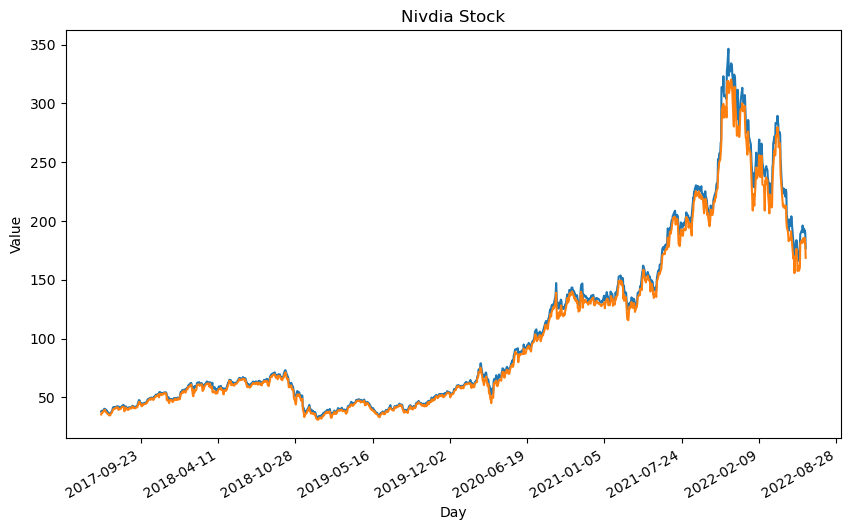

In [69]:
x=df_NVDA_loc.map(lambda t: t[0]).collect()
y1=df_NVDA_loc.map(lambda t: t[1]).collect()
y2=df_NVDA_loc.map(lambda t: t[2]).collect()


# Convert 'x' to datetime format
x = [mdates.datestr2num(i) for i in x]

plt.figure(figsize=(10, 6))
# Plot y1 (high)
plt.plot_date(x, y1, linestyle='solid', marker='None', label='High')

# Plot y2 (low)
plt.plot_date(x, y2, linestyle='solid', marker='None', label='Low')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Nivdia Stock')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200)) 
plt.gcf().autofmt_xdate()  

plt.show()

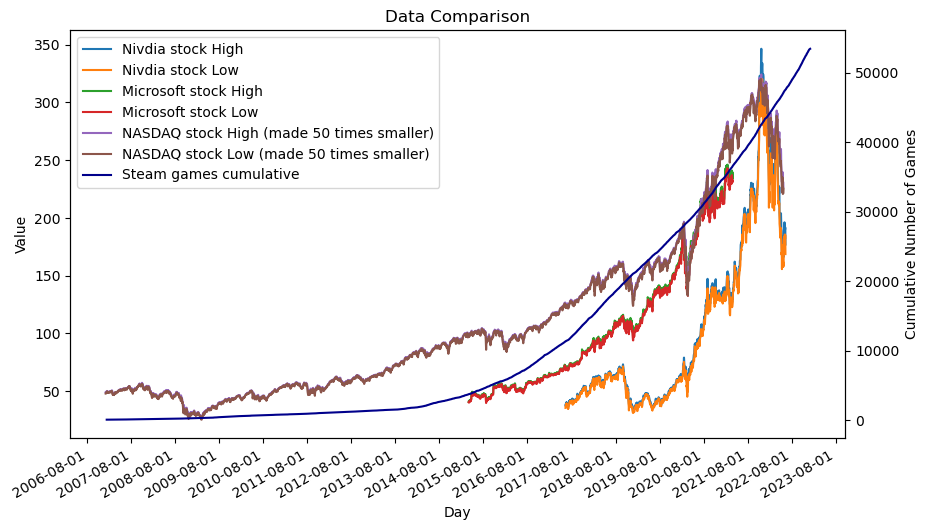

In [108]:
plt.figure(figsize=(10, 6))

plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Data Comparison')


x1=df_NVDA_loc.map(lambda t: t[0]).collect()
y11=df_NVDA_loc.map(lambda t: t[1]).collect()
y12=df_NVDA_loc.map(lambda t: t[2]).collect()

x1 = [mdates.datestr2num(i) for i in x1]


x2=df_MS_loc.map(lambda t: t[0]).collect()
y21=df_MS_loc.map(lambda t: t[1]).collect()
y22=df_MS_loc.map(lambda t: t[2]).collect()

x2 = [mdates.datestr2num(i) for i in x2]

x3=df_NAS_loc.map(lambda t: t[0]).collect()
y31=df_NAS_loc.map(lambda t: t[1]).collect()
y32=df_NAS_loc.map(lambda t: t[2]).collect()

x3 = [mdates.datestr2num(i) for i in x3]


x4 = df_steam_loc.map(lambda t: t[0]).collect()
y41 = df_steam_loc.map(lambda t: t[1]).collect()

y42 = df_steam_loc.map(lambda t: t[2]).collect()

x4 = [mdates.datestr2num(i) for i in x4]


# Plot y1 (high)
plt.plot(x1, y11, label='Nivdia stock High')

# Plot y2 (low)
plt.plot(x1, y12, label='Nivdia stock Low')

# Plot y1 (high)
plt.plot(x2, y21, label='Microsoft stock High')

# Plot y2 (low)
plt.plot(x2, y22, label='Microsoft stock Low')


# Plot y1 (high)
plt.plot(x3, y31, label=f'NASDAQ stock High (made {scale} times smaller)')

# Plot y2 (low)
plt.plot(x3, y32, label=f'NASDAQ stock Low (made {scale} times smaller)')



handles1, labels1 = plt.gca().get_legend_handles_labels()

# Create a secondary y-axis
ax2 = plt.gca().twinx()

# Plot on the secondary y-axis


ax2.plot(x4, y42, color='darkblue', label='Steam games cumulative') 


# ax2.plot(x4, y41, color='blue', label='Steam games daily') 
ax2.set_ylabel('Cumulative Number of Games')


handles2, labels2 = ax2.get_legend_handles_labels()

# Combine the handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

plt.legend(handles, labels)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))  
plt.gcf().autofmt_xdate() 

plt.show()
